In [54]:
import shutil
from pathlib import Path
import math
from dataclasses import dataclass

from databases.db_models import DBPost
from databases.external import DBConfig, SQliteConnection
from databases.platform_db_mgmt import PlatformDB
from datetime import datetime
from typing import Optional

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sqlalchemy import select, BinaryExpression, func

from src.const import BASE_DATA_PATH

stats_copy_path = BASE_DATA_PATH / "stats_copy.sqlite"

def make_stats_copy(db_path: Path):
    shutil.copy(db_path, stats_copy_path)


make_stats_copy(BASE_DATA_PATH / "twitter.sqlite")

# old..
platform_db = PlatformDB("twitter", DBConfig(db_connection=SQliteConnection(db_path=stats_copy_path)))

db = platform_db.db_mgmt


# todo use misc.helper
def get_posts(platform: str,
              conditions: Optional[BinaryExpression | list[BinaryExpression]] = None
              ) -> list[DBPost]:
    with db.get_session() as session:
        # Start with a base query
        query = select(
            func.date(DBPost.date_created).label('day'),
            func.count().label('count')
        ).group_by(
            func.date(DBPost.date_created)
        )

        # Platform is required
        query = query.where(DBPost.platform == platform)

        if conditions is not None:
            if isinstance(conditions, list):
                for condition in conditions:
                    query = query.where(condition)
            else:
                query = query.where(conditions)

        # Execute the query and return the results
        result = session.execute(query)
        return result.all()


2025-01-17 17:51:35,390 - ...Databases.databases.db_mgmt - DEBUG - creating db engine with sqlite:////home/rsoleyma/projects/platforms-clients/data/stats_copy.sqlite


In [55]:
def get_year_counts(year: int) -> pd.Series:
    results = get_posts("twitter",
                        conditions=DBPost.date_created.between(
                            datetime(year, 1, 1),
                            datetime(year + 1, 1, 1)
                        ))

    # Convert to pandas Series with days as index
    counts = pd.Series({row[0]: row[1] for row in results})
    return counts


get_year_counts(2023)

2023-01-01    120
2023-01-02    120
2023-01-03    120
2023-01-04    120
2023-01-05    120
             ... 
2023-10-25     72
2023-10-26     72
2023-10-27     72
2023-10-28     72
2023-10-29     72
Length: 244, dtype: int64

In [56]:
import matplotlib.dates as mdates


def plot_daily_items(daily_counts: pd.Series):
    plt.figure(figsize=(12, 6))

    # Convert index to datetime if not already
    if not isinstance(daily_counts.index, pd.DatetimeIndex):
        daily_counts.index = pd.to_datetime(daily_counts.index)

    sns.lineplot(data=daily_counts, color='blue', label='Posts')

    # Zero days highlight
    zero_days = daily_counts[daily_counts == 0]
    if not zero_days.empty:
        plt.scatter(zero_days.index, zero_days.values,
                    color='red', s=10, label='No Posts',
                    zorder=5)

    plt.title('Daily Post Count (Red Dots = No Posts)')
    plt.xlabel('Date')
    plt.ylabel('Number of Posts')

    # Improved x-axis labels
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45)

    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    return plt


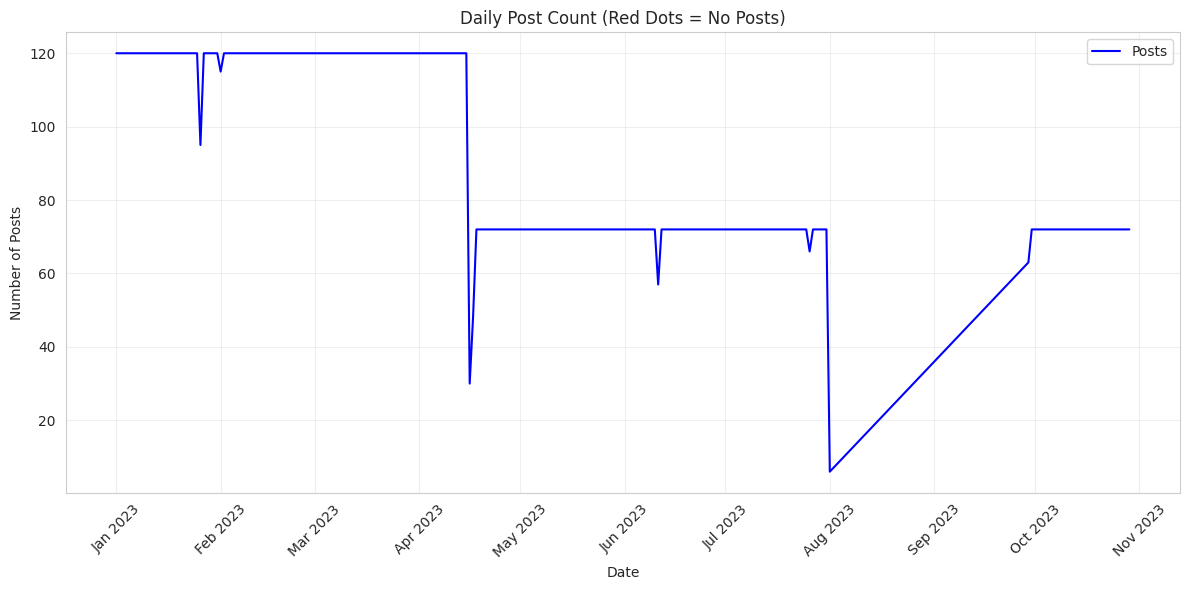

In [61]:
yc_2023 = get_year_counts(2023)
plot = plot_daily_items(yc_2023)
plot.show()

In [58]:
from databases.db_models import DBCollectionTask
from sqlalchemy.orm import contains_eager


# todo use misc.helper
def get_posts_w_task(platform: str,
                     conditions: Optional[BinaryExpression | list[BinaryExpression]] = None
                     ) -> list[DBPost]:
    with db.get_session() as session:
        # Start with a base query
        query = select(DBPost, DBCollectionTask).join(
            DBCollectionTask,
            DBPost.collection_task_id == DBCollectionTask.id
        ).options(
            contains_eager(DBPost.collection_task)
        )

        # Platform is required
        query = query.where(DBPost.platform == platform)

        if conditions is not None:
            if isinstance(conditions, list):
                for condition in conditions:
                    query = query.where(condition)
            else:
                query = query.where(conditions)

        # Execute the query and return the results
        res = session.execute(query).all()
        return [(post.model(), post_col_task.model()) for post, post_col_task in res]


# jan_2022 = get_posts_w_task("youtube", conditions=DBPost.date_created.between(
#     datetime(2022, 1, 1),
#     datetime(2022, 2, 1)
# ))

In [16]:
# for post, post_col in jan_2022:
#     print(post_col.collection_config)

# len(jan_2022), len([_ for _, post_col in jan_2022 if post_col.collection_config.get("location")])

(3327, 2616)

In [59]:
def get_all_posts_sorted(platform: str,
                         conditions: Optional[BinaryExpression | list[BinaryExpression]] = None
                         ) -> list[DBPost]:
    with db.get_session() as session:
        # Start with a base query
        query = select(DBPost)

        # Platform is required
        query = query.where(DBPost.platform == platform)

        if conditions is not None:
            if isinstance(conditions, list):
                for condition in conditions:
                    query = query.where(condition)
            else:
                query = query.where(conditions)

        query.order_by(DBPost.date_created)
        # Execute the query and return the results
        result = session.execute(query)
        for post in result.scalars():
            yield post.model()


In [60]:
from dataclasses import field
from collections import Counter
from datetime import date


@dataclass
class PostDayCollection:
    day: date
    hour_counts: Counter[int, int] = field(default_factory=Counter)

    def add_post(self, post_hour: int):
        self.hour_counts[post_hour] += 1

    def all_hours(self) -> bool:
        return len(day.hour_counts) == 24

    def is_full(self, min_count: int = 3) -> bool:
        return all(count >= min_count for count in self.hour_counts.values())

    def get_incomplete_hours(self, min_count: int = 3) -> list[int]:
        incomplete_hours = []
        for h in range(0,24):
            if self.hour_counts.get(h,0) < min_count:
                incomplete_hours.append(h)
        return incomplete_hours

@dataclass
class PostCollectionCounts:
    year: int
    days: dict[date, PostDayCollection] = field(default_factory=dict)
    total_posts = 0

    def add_post(self, post: DBPost):
        post_date = post.date_created.date()
        if post_date.year != self.year:
            return  # Skip posts from other years
        post_hour = post.date_created.hour
        self.total_posts += 1
        if post_date not in self.days:
            self.days[post_date] = PostDayCollection(day=post_date)
        self.days[post_date].add_post(post_hour)

    def get_incomplete_days(self, min_count: int) -> list[tuple[date, list[int]]]:
        incomplete_day_hours: list[tuple[date, list[int]]] = []
        for day in self.days.values():
            incomplete_hours = day.get_incomplete_hours(min_count)
            if incomplete_hours:
                incomplete_day_hours.append((day.day, incomplete_hours))
        return incomplete_day_hours

collection = PostCollectionCounts(2023)

all_posts = get_all_posts_sorted("twitter")
for post in all_posts:
    collection.add_post(post)

print(collection.get_incomplete_days(3))

[(datetime.date(2023, 1, 26), [14, 15, 18, 19, 20]), (datetime.date(2023, 2, 1), [19]), (datetime.date(2023, 4, 16), [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]), (datetime.date(2023, 4, 17), [0, 1, 2, 3, 4, 5, 6, 7]), (datetime.date(2023, 6, 11), [11, 12, 13, 14, 15]), (datetime.date(2023, 7, 26), [5, 9]), (datetime.date(2023, 8, 1), [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]), (datetime.date(2023, 9, 29), [0, 1, 2])]


In [46]:
# collection.total_posts

22317

In [47]:
for day in collection.days.values():

    min_ = math.inf
    max_ = 0
    for h, hour_c in day.hour_counts.items():
        min_ = min(min_, hour_c)
        max_ = max(max_, hour_c)
        if hour_c < 3:
            print(day.day, h, hour_c)
    #print(day.day, min_,max_)

2023-01-26 19
2023-02-01 23
2023-04-16 6
2023-04-17 16
2023-06-11 19
2023-07-26 22
2023-08-01 2
2023-09-29 21
2023-10-28 15
